# Please put down your weapon. 
> You have twenty seconds to comply.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/posts/2020-12-17-Put-Down-Your-Weapon/Put-Down-Your-Weapon.jpg

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Image Classification

Up to this point we have created a Neural Network using only 4 lines of code with fastai's high level API and we have created a Neural Network from scratch using PyTorch only for its tensors and back-propogation functions. Now we are going to start trying to coalesce these two methodologies and attempt to meet somewhere in the middle.

In this chapter we are looking at multi-image classification, it is quite a step up from the work we did in Chapter 2 where we identified Star Wars Robot or the simple binary classification in Chapter 4 where we attempted to disambiguate between hand written characters of 3s and 7s. Here we are going to attempt to identify breeds of cats and dogs with 37 different catagories. It is no mean feat. 

Also if you are interested in the name of this blog post, its one of my favourite scenes from Robocop, where ED-209 cannot identify whether or not Kinney has reliquished his firearm. Let's hope we can do a better job here!

## From Dogs and Cats to Pet Breeds

Thankfully the fantastic team at fastai have provided a dataset for us, moving forward and looking at our own problems we will need to create them ourselves, but for now we can simply run `untar_data` and pass in the `URLs.PETS` url to download, extract and return a local path to the data

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

Again here we can use the `ls` function to look inside our directory to what our dataset folder contains

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

Lets take a look inside the `images` folder. Here we can see that we have 7393 images and the first ten paths. Similarly to our example in Chapter 1, file names that start with a capital letter are `Cat` breeds and file names beginning with lowercase letters are `Dog` breeds. But we need to differtiate them even further in this example, into the specific breeds.  

In [6]:
(path/"images").ls()

(#7393) [Path('images/Ragdoll_197.jpg'),Path('images/newfoundland_36.jpg'),Path('images/boxer_107.jpg'),Path('images/scottish_terrier_5.jpg'),Path('images/yorkshire_terrier_136.jpg'),Path('images/keeshond_21.jpg'),Path('images/beagle_188.jpg'),Path('images/chihuahua_139.jpg'),Path('images/basset_hound_44.jpg'),Path('images/Russian_Blue_135.jpg')...]

We can do that using a Regular Expression. The format of the file names are:

{ANIMAL_BREED}\_{INTEGER}.{EXTENSION}

Regular expressions are a fantastic utility that can parse strings are return specific data from them. There is a great resource that can be found as part of the [fastai nlp course](https://github.com/fastai/course-nlp/blob/master/4-regex.ipynb). First lets store first image path into a variable. 

In [7]:
fname = (path/"images").ls()[0]

Here by using our regular expression `r'(.+)_\d+.jpg$'` we are able to extract the name of our first breed.

`(.+)` this part of the expression is looking for the breed using `re.findall()` and it will return that value. This represents the {ANIMAL_BREED} part of the name format shown above. 

`_\d+.jpg$'` this part of the expression is looking for the underscore `_` the {INTEGER} `\d+` and the .{EXTENSION} `.jpg` 

Here we can see it worked! By passing in our first image path our Regular Expression returns `Ragdoll`

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Ragdoll']

So now, lets create a DataBlock from our dataset. We define that our Dependent Variable is of type `ImageBlock` and our Independent Variable is of type `CatagoryBlock`.

Here we are using a new function and a new class. Here we are passing `RegexLabeller` object and the `name` variable to fastai's `using_attr` function. This will perform our regex segmentation on every files `name` attribute to return our image labels into the DataBlocks `get_y` argument.

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

We also have two new lines that perform resizing operations. Once on a per item level and one at a batch level, this is a process the team at fastai call `Presizing`

## Presizing

![](2020-12-17-Put-Down-Your-Weapon/Presizing.jpg)

- Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions.
- Compose all of the common augmentation operations (including a resize to the final target size) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

The first step, the resize, creates images large enough that they have spare margin to allow further augmentation transforms on their inner regions without creating empty zones. This transformation works by resizing to a square, using a large crop size. On the training set, the crop area is chosen randomly, and the size of the crop is selected to cover the entire width or height of the image, whichever is smaller.

In the second step, the GPU is used for all data augmentation, and all of the potentially destructive operations are done together, with a single interpolation at the end.

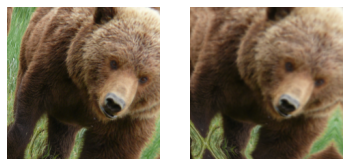

In [10]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd().parent/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

As you can see this `Presizing` process gives significantly better quality results

### Checking and Debugging a DataBlock

So now we can check out our `DataBlock` by using `show_batch`

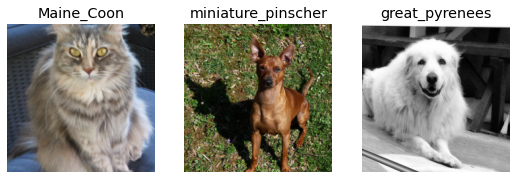

In [11]:
dls.show_batch(nrows=1, ncols=3)

This example shows us a summary of a `DataBlock` if we didn't utilise our `item_tfms` and `batch_tfms`.

- Sets up transforms pipeline
- Builds one sample
- Collects the items
- Builds one batch

Before it falls over because our images are of different dimensions. `summary` is really useful to see what has happened in building your `DataBlock` and image tranformation pipeline and gives detailed explaination of the the errors

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Collecting items from /storage/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/english_setter_53.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x400
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/oxford-iiit-pet/images/english_setter_53.jpg
    applying partial gives
      english_setter
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(19)

Final sample: (PILImage mode=RGB size=500x400, TensorCategory(19))


Collecting items from /storage/data/oxford-iiit-pet/images
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x400, TensorCategory(19))
    applying ToTensor gives
      (TensorImage of size 3x400x500, TensorCategory(19))

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch
Error! It's not possible to collate your items in a batch
Could not collate the 0-th members of your tuples because got the following shapes
(3, 400, 500),(3, 225, 300),(3, 225, 300),(3, 332, 500)

Now lets create a `cnn_learner` pass in our `dataloader` along with the `resnet34` architecture and train the last 2 layers of the network.

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.493833,0.319699,0.108254,01:41


epoch,train_loss,valid_loss,error_rate,time
0,0.520890,0.307597,0.102165,02:12
1,0.341706,0.230789,0.075101,02:11


But we didn't specify a loss function, thankfully fastai knows which loss fucntions are useful for each type of learner. So what did it pick?

In [14]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

So what is Cross-Entropy Loss?

## Cross-Entropy Loss

### Viewing Activations and Labels

A sensible place to start is taking a look at our data, here we can destructure `one_batch` of from our data loader and see our independent variable `y`

In [15]:
x,y = dls.one_batch()

In [16]:
y

TensorCategory([34, 23,  4, 25, 32,  4, 33, 28, 16, 17,  0, 21,  5,  9, 20,  8, 31, 11, 34, 21, 13, 10, 20,  4, 35, 17, 25, 31, 32,  3,  9, 35, 32, 30,  5, 31,  6, 15, 31, 23, 17, 33,  7, 20, 33, 18, 31, 18,
        21, 24, 20, 33, 10,  1, 32, 21,  1, 17, 23, 23, 19,  4, 11, 21], device='cuda:0')

Here we can see all of our classifications, each index value represents one of the breeds within our dataset. We can see what that index value pertains to by using the `vocab` function, but it isn't entirely relevant in this example.

Let's now make a prediction using `get_preds`

In [17]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.4188e-06, 9.2919e-07, 8.1356e-05, 4.2431e-06, 1.2433e-05, 6.9899e-06, 2.5417e-06, 8.4320e-06, 4.2290e-06, 1.2586e-04, 1.9387e-04, 3.8595e-05, 2.4883e-02, 6.4488e-03, 2.0814e-06, 1.1752e-04,
        1.0921e-04, 2.7717e-02, 2.0989e-06, 3.3488e-05, 2.0668e-05, 2.7205e-03, 2.6016e-05, 5.9952e-05, 5.7038e-05, 2.0636e-06, 5.0264e-05, 9.4108e-06, 6.0596e-06, 1.1552e-03, 3.6774e-04, 1.9417e-04,
        5.5275e-05, 1.2116e-04, 9.3534e-01, 7.1628e-06, 1.4299e-05])

Here we can see that the highest value prediction is `9.3534e-01` and it is significantly higher than any of the other predictions. There is also another attribute of these predictions

In [18]:
len(preds[0]),preds[0].sum()

(37, tensor(1.))

They all sum to 1.

### Softmax

Lets start with a simple example from Chapter 4, lets draw a graph of the `sigmoid` function

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


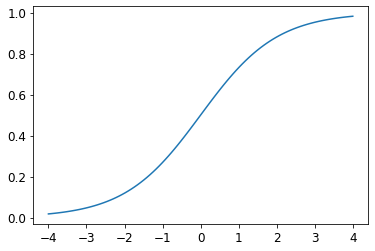

In [19]:
plot_function(torch.sigmoid, min=-4,max=4)

In [20]:
#hide
torch.random.manual_seed(42);

If we remember correctly by passing in extremely high numbers the result with tend towards 1, and extremely low numbers will tend towards 0. This will aid us in normalizing our predicted results.

If we create some simple example data that could be representative of the predictions of whether an input to the network is either a 3 or a 7 we might get a tensor similar to our data below

In [21]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

If we pass these values through our `sigmoid` function we get two new values, but they aren't particularly helpful in giving us a concrete predicition on whether or not our inputs are 3s or 7s, so how can we remedy this?

In [22]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

Maybe instead of looking at the values independently we want to pass the difference of the predictions to the sigmoid fucntion and have `1 - the sigmoid of the difference` being the resultant prediction

In [23]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

The additional benefit is that the results are guaranteed to sum to 1 effectively giving us a percentage. 

- **60.25%** chance of being a **3** vs **39.75%** chance of being a **7**

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Note: The softmax function looks like this:

In [1]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

Exponential function (exp): Literally defined as e**x, where e is a special number approximately equal to 2.718. It is the inverse of the natural logarithm function. Note that exp is always positive, and it increases very rapidly!

If we have three output activations, such as in our droid classifier, calculating softmax for a single droid image would then look like something like this:

![](2020-12-17-Put-Down-Your-Weapon/Comparison.jpg)

### Log Likelihood

So now that we have our predictions how do calculate our loss?

If we remeber back in Chapter 4, we created our `mnist_loss` function

In [ ]:
def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()

Here we determined that if the target was 1 we would return 1 - our input else the input value, this would tell us how far our prediction was from the actual target. 

But this will only work in the binary case, what if we would like to solve for more classes? We can simply index into our softmax activations! Sounds to good to be true. Lets take a look at our toy example above

In [25]:
targ = tensor([0,1,0,1,1,0])

Here we have defined our target indices in a tensor

In [26]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

Our softmax activations are the same as they are above

But by looking into each row and retrieving only the column indexed in that row we can determine our loss

In [27]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [28]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


The nice thing about this method is that it scales to any number of catagories. If we were doing the full MNIST classification, identifying all ten digits, we would be indexing into a column of ten values instead of the two in this example

In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

By making our softmax activations negative, we are getting the identical results as the PyTorch function `nll_loss` or `Negative Log Likelihood`, here we can see that the function provided by PyTorch and fastai are simple shortcuts to work we can do ourselves

warning: Confusing Name, Beware: The nll in nll_loss stands for "negative log likelihood," but it doesn't actually take the log at all! It assumes you have already taken the log. PyTorch has a function called log_softmax that combines log and softmax in a fast and accurate way. nll_loss is designed to be used after log_softmax.

### Taking the Log

y = b**a

a = log(y,b)

In this case, we're assuming that log(y,b) returns log y base b. However, PyTorch actually doesn't define log this way: log in Python uses the special number e (2.718...) as the base.

Perhaps a logarithm is something that you have not thought about for the last 20 years or so. But it's a mathematical idea that is going to be really critical for many things in deep learning, so now would be a great time to refresh your memory. The key thing to know about logarithms is this relationship:

log(a*b) = log(a)+log(b)

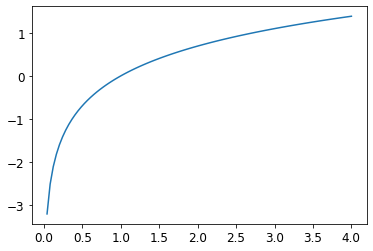

In [31]:
plot_function(torch.log, min=0,max=4)

In [32]:
loss_func = nn.CrossEntropyLoss()

In [33]:
loss_func(acts, targ)

tensor(1.8045)

In [34]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

An interesting feature about cross-entropy loss appears when we consider its gradient. The gradient of cross_entropy(a,b) is just softmax(a)-b. Since softmax(a) is just the final activation of the model, that means that the gradient is proportional to the difference between the prediction and the target. This is the same as mean squared error in regression (assuming there's no final activation function such as that added by y_range), since the gradient of (a-b)**2 is 2*(a-b). Because the gradient is linear, that means we won't see sudden jumps or exponential increases in gradients, which should lead to smoother training of models.

## Model Interpretation

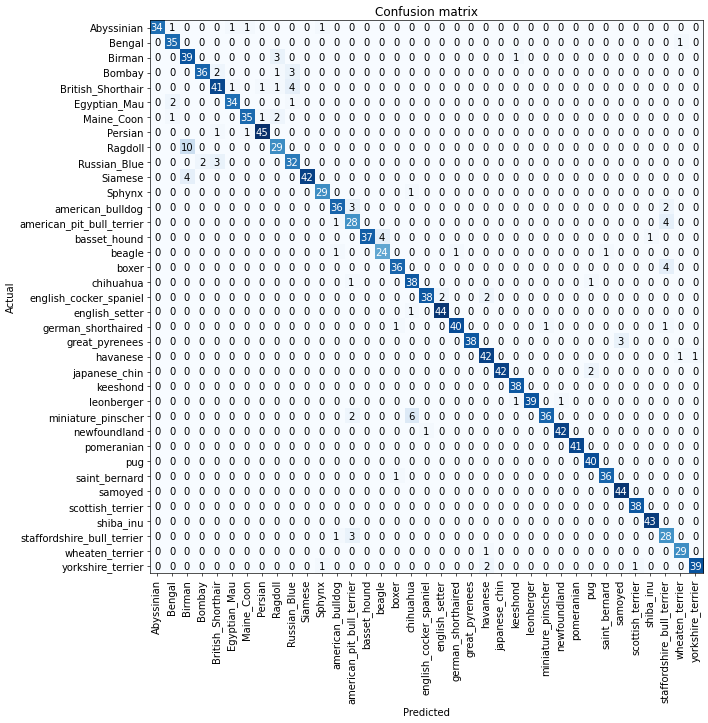

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 10), ('miniature_pinscher', 'chihuahua', 6)]

## Improving Our Model

### The Learning Rate Finder

In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.654461,4.516049,0.505413,01:40


epoch,train_loss,valid_loss,error_rate,time
0,4.329690,8.718549,0.822733,02:12


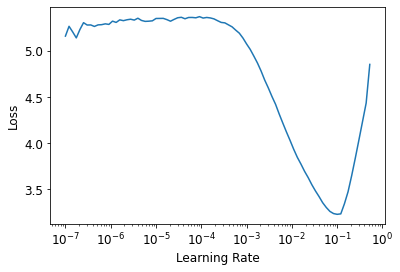

In [39]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [40]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 4.37e-03


In [41]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.352067,0.302961,0.094723,01:40


epoch,train_loss,valid_loss,error_rate,time
0,0.533749,0.302427,0.086604,02:11
1,0.334618,0.228772,0.072395,02:11


### Unfreezing and Transfer Learning

In [42]:
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `freeze` for `freeze_epochs` then with `unfreeze` from `epochs` using discriminative LR"
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py
Type:      method

In [43]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.102643,0.279781,0.094723,01:40
1,0.535196,0.246822,0.076455,01:40
2,0.327852,0.198139,0.066306,01:40


In [44]:
learn.unfreeze()

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=1.5848931980144698e-06)

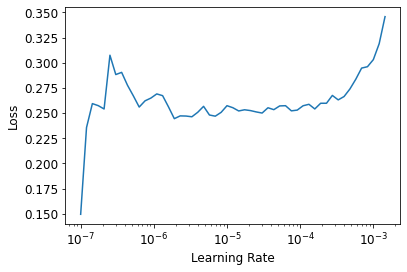

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.255147,0.191486,0.060217,02:11
1,0.255074,0.178717,0.060217,02:11
2,0.228266,0.178046,0.064276,02:12
3,0.209520,0.178112,0.056157,02:11
4,0.186808,0.177464,0.056157,02:11
5,0.184688,0.172256,0.054804,02:12


### Discriminative Learning Rates

In [47]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.139847,0.307070,0.099459,01:41
1,0.536971,0.257561,0.081867,01:40
2,0.338579,0.213168,0.071042,01:40


epoch,train_loss,valid_loss,error_rate,time
0,0.267892,0.210070,0.069012,02:12
1,0.247653,0.196744,0.066982,02:12
2,0.242534,0.189713,0.062923,02:12
3,0.213890,0.183064,0.059540,02:12
4,0.201939,0.182476,0.066306,02:12
5,0.173591,0.167041,0.052097,02:13
6,0.165675,0.169903,0.055480,02:13
7,0.151925,0.167067,0.053451,02:12
8,0.135530,0.170335,0.052774,02:12
9,0.122693,0.162749,0.052097,02:12


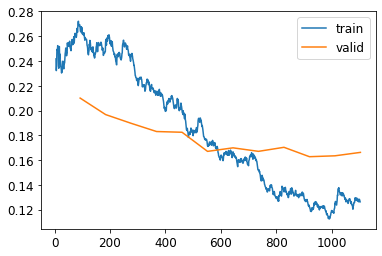

In [48]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [49]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.421636,0.300777,0.099459,02:23
1,0.621208,0.274879,0.085250,02:24
2,0.435900,0.276002,0.087957,02:23


epoch,train_loss,valid_loss,error_rate,time
0,0.278140,0.283758,0.089986,03:13
1,0.315363,0.287254,0.081867,03:14
2,0.275569,0.261106,0.074425,03:17
3,0.157947,0.233280,0.059540,03:15
4,0.084224,0.203565,0.059540,03:15
5,0.061835,0.193485,0.054127,03:15


## Conclusion

## Questionnaire

**Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?**

This concept is known as presizing. Data augmentation is often applied to the images and in fastai it is done on the GPU. However, data augmentation can lead to degradation and artifacts, especially at the edges. Therefore, to minimize data destruction, the augmentations are done on a larger image, and then RandomResizeCrop is performed to resize to the final image size.

**If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.**

See above

**What are the two ways in which data is most commonly provided, for most deep learning datasets?**

- Individual files representing items of data, such as text documents or images.
- A table of data, such as in CSV format, where each row is an item, each row which may include filenames providing a connection between the data in the table and data in other formats such as text documents and images.

**Give two examples of ways that image transformations can degrade the quality of the data.**

- Rotation can leave empty areas in the final image
- Other operations may require interpolation which is based on the original image pixels but are still of lower image quality

**What method does fastai provide to view the data in a `DataLoaders`?**

DataLoader.show_batch

**What method does fastai provide to help you debug a `DataBlock`?**

DataBlock.summary

**Should you hold off on training a model until you have thoroughly cleaned your data?**

No. It is best to create a baseline model as soon as possible.

**What are the two pieces that are combined into cross-entropy loss in PyTorch?**

Cross Entropy Loss is a combination of a Softmax function and Negative Log Likelihood Loss.

**What are the two properties of activations that softmax ensures? Why is this important?**

It makes the outputs for the classes add up to one. This means the model can only predict one class. Additionally, it amplifies small changes in the output activations, which is helpful as it means the model will select a label with higher confidence (good for problems with definite labels).

**When might you want your activations to not have these two properties?**

When you have multi-label classification problems (more than one label possible).

**Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?**

Because torch.where can only select between two possibilities while for multi-class classification, we have multiple possibilities.

**What is the value of log(-2)? Why?**

This value is not defined. The logarithm is the inverse of the exponential function, and the exponential function is always positive no matter what value is passed. So the logarithm is not defined for negative values.

**What are two good rules of thumb for picking a learning rate from the learning rate finder?**

Either one of these two points should be selected for the learning rate:

- one order of magnitude less than where the minimum loss was achieved (i.e. the minimum divided by 10)
- the last point where the loss was clearly decreasing.

**What two steps does the `fine_tune` method do?**

- Train the new head (with random weights) for one epoch
- Unfreeze all the layers and train them all for the requested number of epochs

**In Jupyter Notebook, how do you get the source code for a method or function?**

Use ?? after the function ex: DataBlock.summary??

**What are discriminative learning rates?**

Discriminative learning rates refers to the training trick of using different learning rates for different layers of the model. This is commonly used in transfer learning. The idea is that when you train a pretrained model, you don’t want to drastically change the earlier layers as it contains information regarding simple features like edges and shapes. But later layers may be changed a little more as it may contain information regarding facial feature or other object features that may not be relevant to your task. Therefore, the earlier layers have a lower learning rate and the later layers have higher learning rates.

**How is a Python `slice` object interpreted when passed as a learning rate to fastai?**

The first value of the slice object is the learning rate for the earliest layer, while the second value is the learning rate for the last layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range.

**Why is early stopping a poor choice when using 1cycle training?**

If early stopping is used, the training may not have time to reach lower learning rate values in the learning rate schedule, which could easily continue to improve the model. Therefore, it is recommended to retrain the model from scratch and select the number of epochs based on where the previous best results were found.

**What is the difference between `resnet50` and `resnet101`?**

The number 50 and 101 refer to the number of layers in the models. Therefore, ResNet101 is a larger model with more layers versus ResNet50. These model variants are commonly as there are ImageNet-pretrained weights available.

**What does `to_fp16` do?**

This enables mixed-precision training, in which less precise numbers are used in order to speed up training.

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.